Number of reference keypoints detected:  150
Number of align image keypoints detected:  150


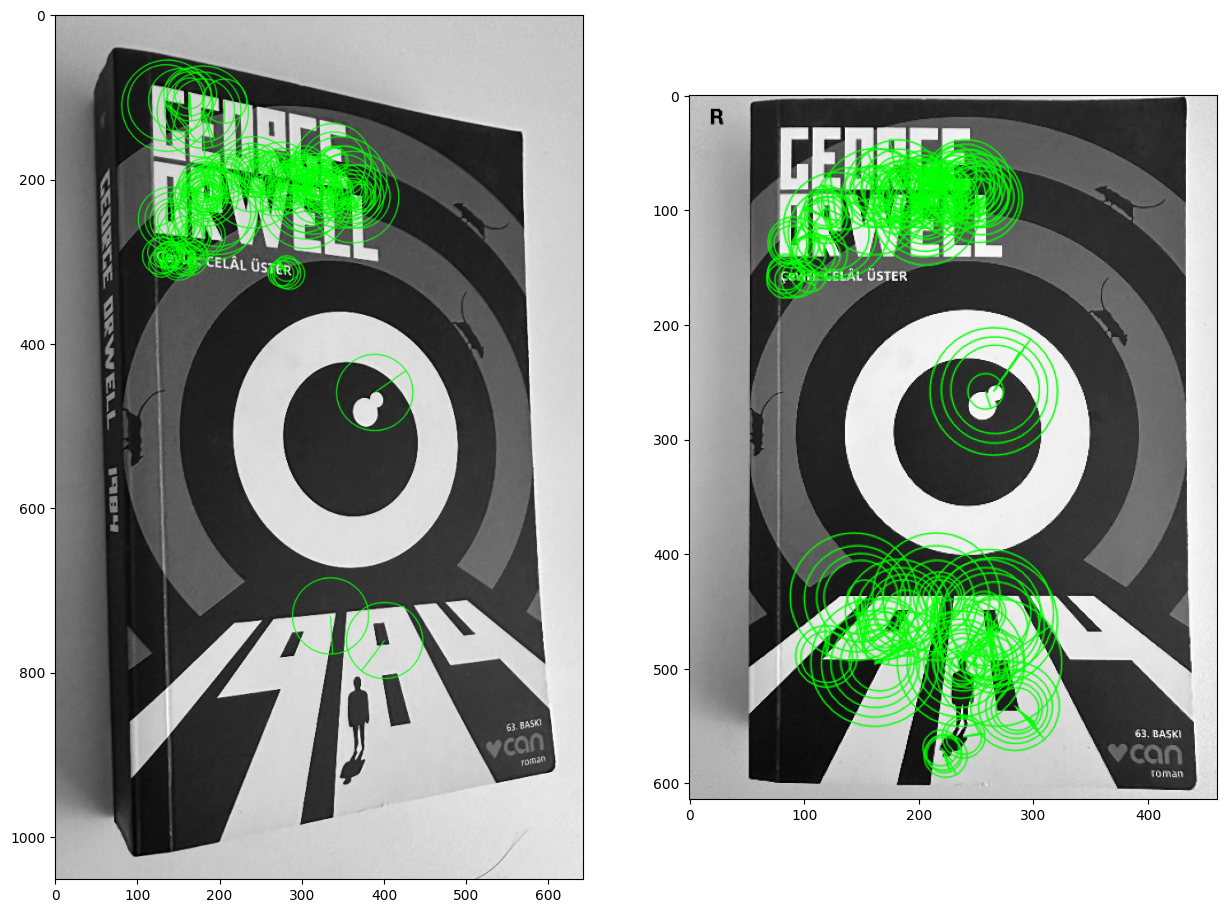

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgAlign = cv2.imread('./images/george6_resized.jpeg', cv2.IMREAD_GRAYSCALE)
imgReference = cv2.imread('./images/george1e_resized.jpeg', cv2.IMREAD_GRAYSCALE)

h, w = imgReference.shape
orb = cv2.ORB_create(150)

referenceKp = orb.detect(imgReference, None)
alignKp = orb.detect(imgAlign, None)

imgReference = cv2.drawKeypoints(imgReference, referenceKp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgAlign = cv2.drawKeypoints(imgAlign, alignKp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print("Number of reference keypoints detected: ", len(referenceKp))
print("Number of align image keypoints detected: ", len(alignKp))

plt.figure(figsize=(15, 15))
plt.subplot(122)
plt.imshow(imgReference)
plt.subplot(121)
plt.imshow(imgAlign)
plt.show()

150
40.0 55.0
Number of good matches:  15


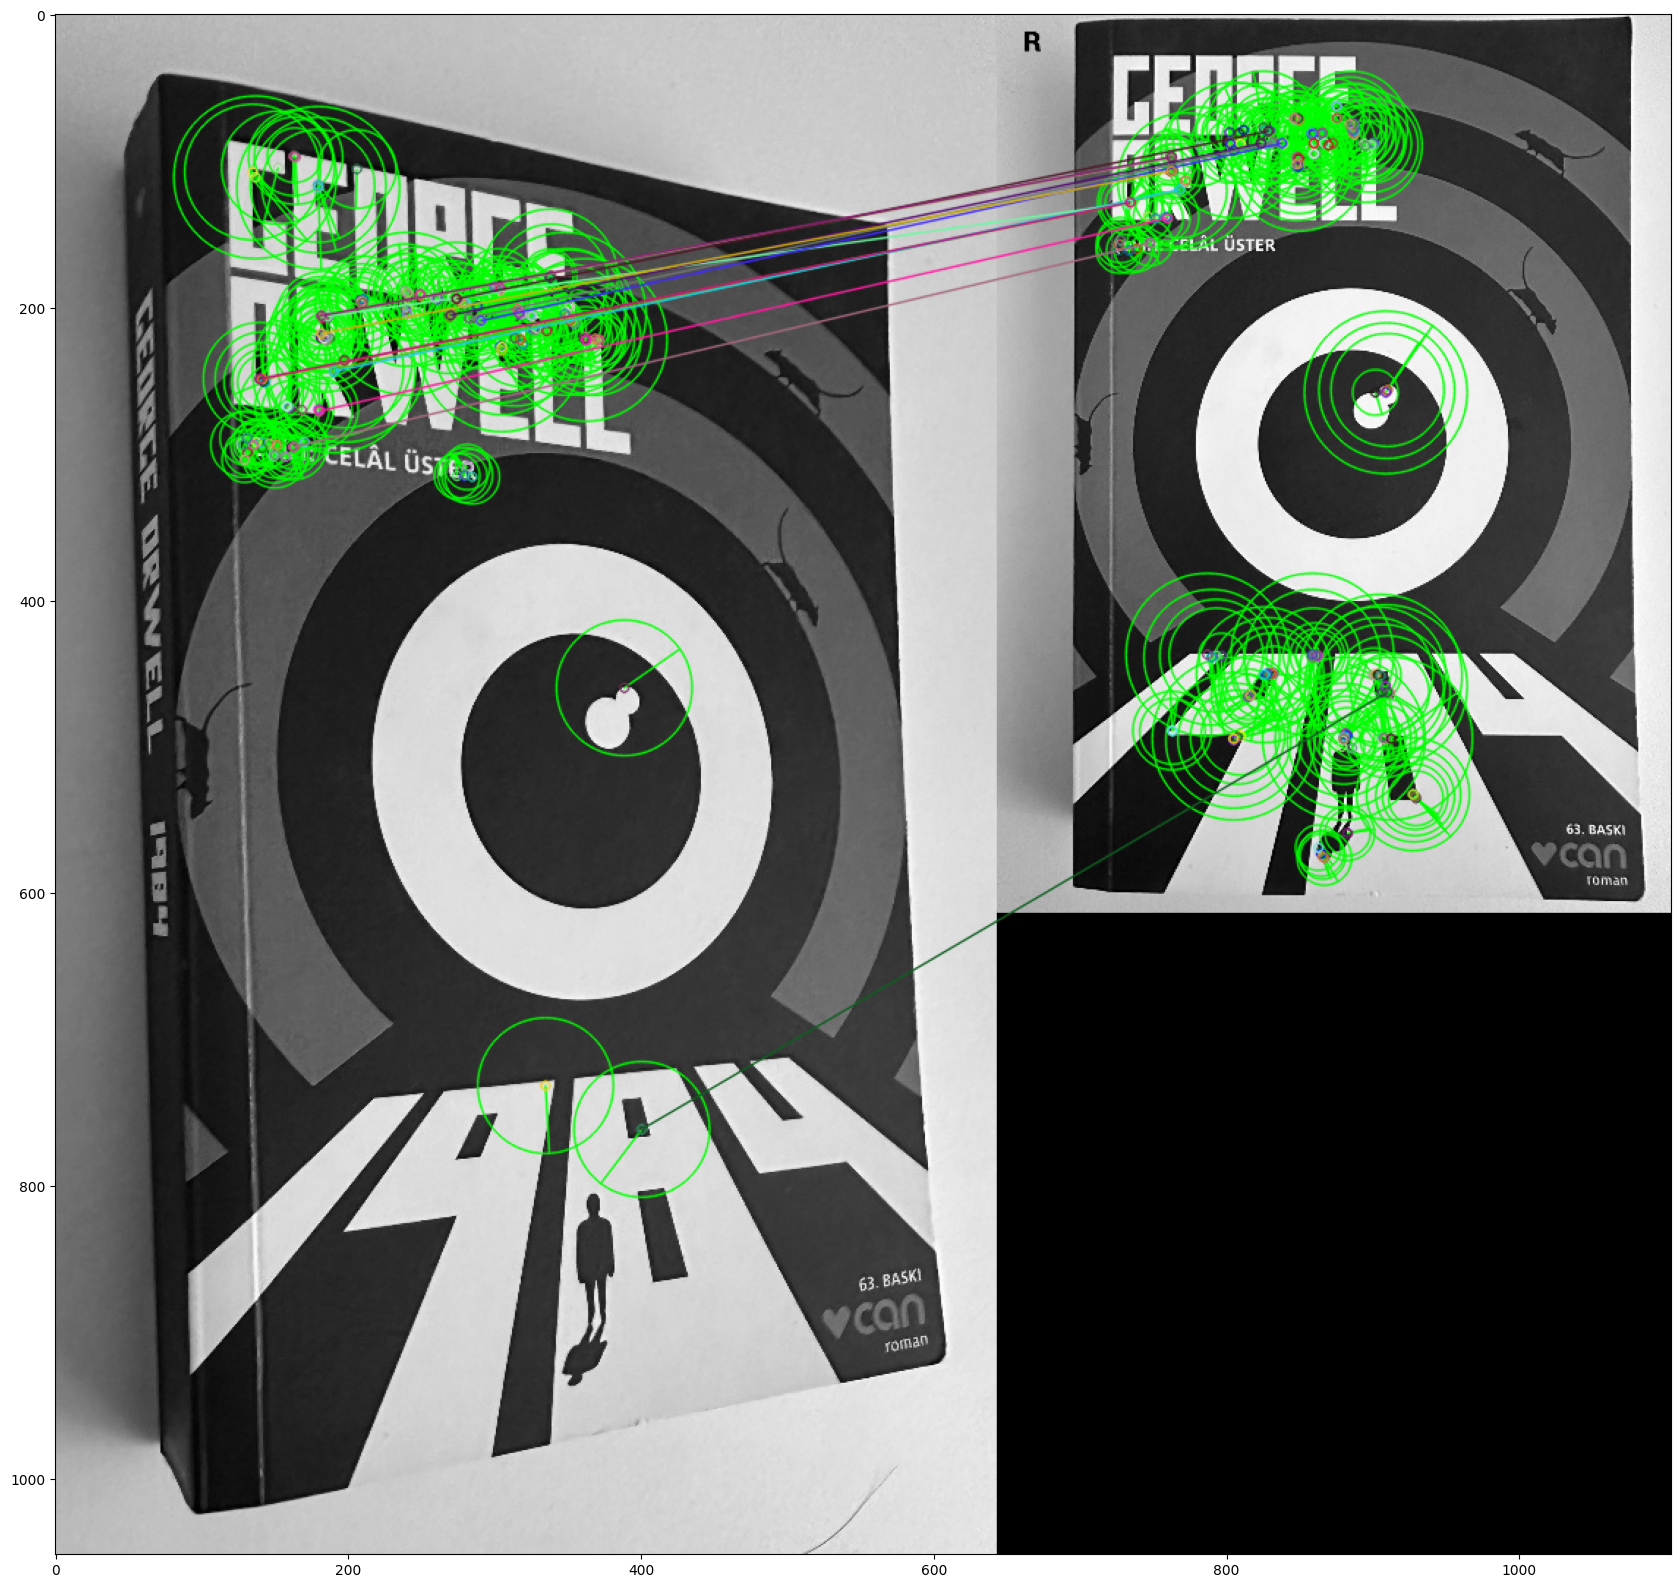

(<matplotlib.image.AxesImage at 0x7f67fbb13670>, None)

In [35]:
referenceKp, referenceDes = orb.compute(imgReference, referenceKp)
alignKp, alignDes = orb.compute(imgAlign, alignKp)

print(len(referenceKp))

matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(alignDes, referenceDes, None)


FLANN_INDEX_KDTREE = 1

index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
# matches = flann.knnMatch(alignDes, referenceDes, k=2)

matches = sorted(matches, key=lambda x: x.distance, reverse=False)
numGoodMatches = int(len(matches) * 0.10)
matches = matches[:numGoodMatches]

print(f"{matches[0].distance} {matches[-1].distance}")
# print(f"{[for match.distance in matches]}")

src_pts = []
dst_pts = []

for match in matches:
    src_pts.append(alignKp[match.queryIdx].pt)
    dst_pts.append(referenceKp[match.trainIdx].pt)

src_pts = np.float32(src_pts).reshape(-1, 1, 2)
dst_pts = np.float32(dst_pts).reshape(-1, 1, 2)

print("Number of good matches: ", len(matches))


matchedImage = cv2.drawMatches(imgAlign, alignKp, imgReference, referenceKp, matches, None)
plt.figure(figsize=(30, 20))
plt.imshow(matchedImage, 'gray'), plt.show()

Homografi matrisi: 
[[ 5.68643420e-01 -2.58872846e-02  1.18670949e+01]
 [-1.38458116e-01  5.79486241e-01 -3.93751638e+00]
 [-4.06286574e-04 -1.61527863e-05  1.00000000e+00]]


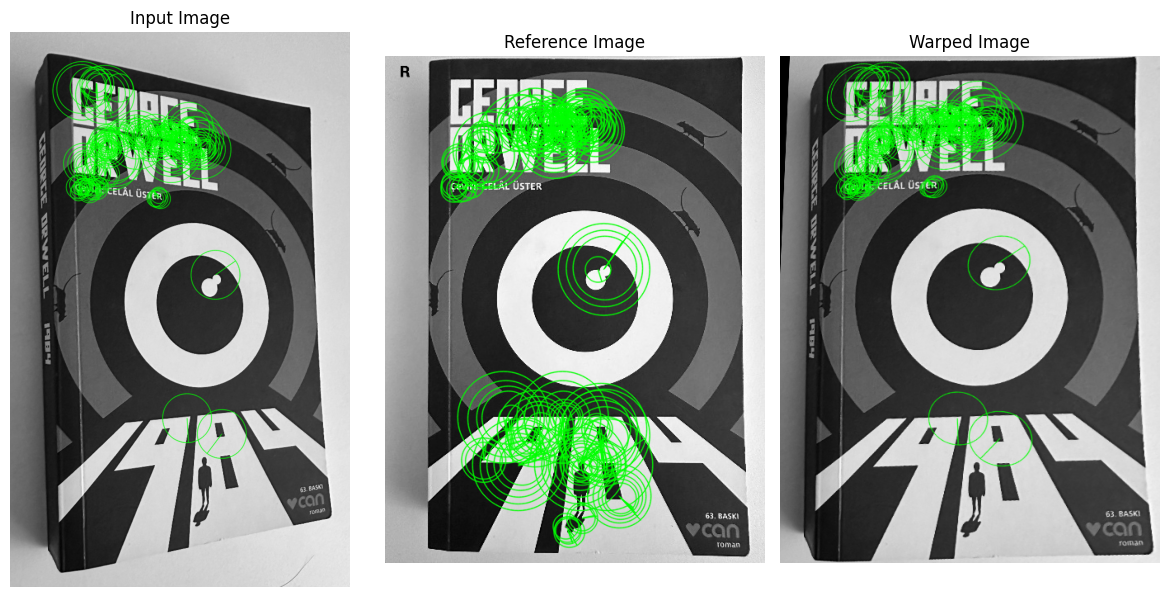

In [38]:

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

print(f"Homografi matrisi: \n{M}")

if M is not None:
    # pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    # dst = cv2.perspectiveTransform(pts, M)
    # imgReference = cv2.polylines(imgReference, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

    im1_reg = cv2.warpPerspective(imgAlign, M, (imgReference.shape[1], imgReference.shape[0]))

    plt.figure(figsize=(12, 6))
    plt.subplot(131), plt.imshow(imgAlign, cmap='gray')
    plt.title('Input Image'), plt.axis('off')

    plt.subplot(132), plt.imshow(imgReference, cmap='gray')
    plt.title('Reference Image'), plt.axis('off')

    plt.subplot(133), plt.imshow(im1_reg, cmap='gray')
    plt.title('Warped Image'), plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Homografi bulunamadı.")